# Scrapping de datos limpios

In [4]:
import requests
from bs4 import BeautifulSoup
import pickle
import pandas as pd
import re
import os

# Base URL para Zona 10
BASE_URL = "https://mapainmueble.com/casas-en-venta-zona-15/"


def get_properties_urls(page_url: str) -> list:
    """Obtiene las URLs de las propiedades desde una página de listado."""
    try:
        req = requests.get(page_url, timeout=10)
        req.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"Error al obtener la página {page_url}: {e}")
        return []
    
    soup = BeautifulSoup(req.text, 'html.parser')
    properties_urls = [h4.a["href"] for h4 in soup.find_all("h4") if h4.a]
    return properties_urls


def get_property_details(property_url: str) -> dict:
    """Extrae los detalles de una propiedad específica."""
    try:
        req = requests.get(property_url, timeout=10)
        req.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"Error al obtener la propiedad {property_url}: {e}")
        return {}
    
    soup = BeautifulSoup(req.text, 'html.parser')
    property_details = {}
    
    detalles_header = soup.find('h4', id='prop_det')
    if detalles_header:
        detalles_section = detalles_header.find_next('div', class_='panel-body')
        if detalles_section:
            for detail in detalles_section.find_all('div', class_='listing_detail'):
                key_elem = detail.find('strong')
                if key_elem:
                    key = key_elem.text.strip(':').strip()
                    value = detail.text.replace(key, '').strip(':').strip()
                    
                    if key in ["Precio", "Parqueos", "Dormitorios", "Baños", "Tamaño de la propiedad"]:
                        cleaned_value = clean_value(value)
                        
                        # Filtrar precios anómalos
                        if key == "Precio" and (cleaned_value is None or cleaned_value < 100000 or cleaned_value > 5000000):
                            cleaned_value = None
                        
                        # Valores predeterminados en caso de que falte información
                        if key == "Precio" and cleaned_value is None:
                            cleaned_value = 300000  # Valor por defecto si falta el precio

                        if key == "Tamaño de la propiedad" and cleaned_value is None:
                            cleaned_value = 200  # Valor por defecto si falta el tamaño (en m²)

                        if key in ["Parqueos", "Dormitorios", "Baños"] and cleaned_value is None:
                            cleaned_value = 0  # Si falta este dato, asumimos 0

                        property_details[key] = cleaned_value
    
    return property_details


def clean_value(value: str):
    """Limpia y convierte valores numéricos a enteros o flotantes, eliminando caracteres no deseados."""
    if not value:
        return None

    # Eliminar caracteres no numéricos excepto el punto decimal
    value = re.sub(r'[^0-9.]', '', value)

    # Detectar valores de metros cuadrados con un '2' extra al final y corregirlos
    value = re.sub(r'2$', '', value)  # Si termina en '2', lo elimina

    # Si hay más de un punto decimal, eliminar los extras dejando solo el primero
    if value.count('.') > 1:
        value = value.replace('.', '', value.count('.') - 1)

    # Validar si el resultado es un número válido
    if re.fullmatch(r'\d+(\.\d+)?', value):  # Coincide con enteros o decimales válidos
        return int(value) if value.isdigit() else float(value)

    return None  # Si no es un número válido, devolver None


# Scraper principal
all_urls = []
max_page_num = 20  # Ajustar según la paginación real de Zona 10

for page_num in range(1, max_page_num + 1):
    page_url = f'{BASE_URL}page/{str(page_num)}/'
    urls_page = get_properties_urls(page_url)
    all_urls += urls_page
    print(f'*** {len(all_urls)} URLs collected ***')

# Guardar URLs recolectadas
data_dir = "P2-Scraping"
os.makedirs(data_dir, exist_ok=True)

with open(os.path.join(data_dir, 'urls_list.pkl'), 'wb') as file:
    pickle.dump(all_urls, file)

# Extraer detalles de cada propiedad
details_data = []

for i, url in enumerate(all_urls):
    result = get_property_details(url)
    details_data.append(result)
    print(f'Details extracted from property {i+1}/{len(all_urls)}...')

# Guardar en CSV con solo datos numéricos
df = pd.DataFrame(details_data)
df = df[["Precio", "Tamaño de la propiedad", "Dormitorios", "Baños", "Parqueos"]]  # Filtrar solo columnas numéricas

# Rellenar valores nulos
for column in ["Precio", "Tamaño de la propiedad"]:
    df[column].fillna(df[column].median(), inplace=True)

for column in ["Dormitorios", "Baños", "Parqueos"]:
    df[column].fillna(0, inplace=True)

df.to_csv(os.path.join(data_dir, 'properties_zona15.csv'), index=False)

print("Scraping completado y datos guardados en P2-Scraping/properties_zona15.csv")


*** 9 URLs collected ***
*** 18 URLs collected ***
*** 27 URLs collected ***
*** 36 URLs collected ***
*** 45 URLs collected ***
*** 54 URLs collected ***
*** 63 URLs collected ***
*** 72 URLs collected ***
*** 81 URLs collected ***
*** 90 URLs collected ***
*** 99 URLs collected ***
*** 108 URLs collected ***
*** 110 URLs collected ***
*** 110 URLs collected ***
*** 110 URLs collected ***
*** 110 URLs collected ***
*** 110 URLs collected ***
*** 110 URLs collected ***
*** 110 URLs collected ***
*** 110 URLs collected ***
Details extracted from property 1/110...
Details extracted from property 2/110...
Details extracted from property 3/110...
Details extracted from property 4/110...
Details extracted from property 5/110...
Details extracted from property 6/110...
Details extracted from property 7/110...
Details extracted from property 8/110...
Details extracted from property 9/110...
Details extracted from property 10/110...
Details extracted from property 11/110...
Details extracted f

/var/folders/yn/vbht61m97rg6wrrbgs95_9k00000gn/T/ipykernel_69676/3472159652.py:123: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].median(), inplace=True)
/var/folders/yn/vbht61m97rg6wrrbgs95_9k00000gn/T/ipykernel_69676/3472159652.py:123: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting val

# Linear regresion models

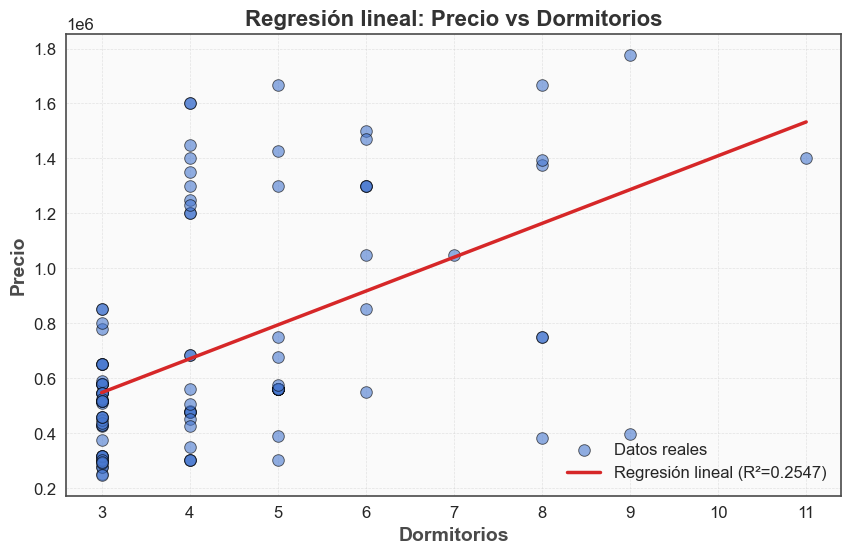

Modelo de regresión lineal: Precio vs Dormitorios
R² = 0.2547



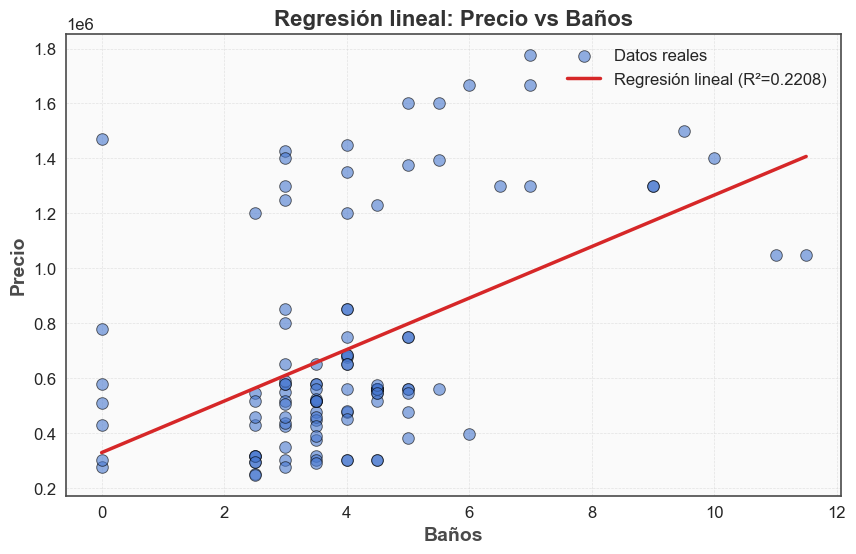

Modelo de regresión lineal: Precio vs Baños
R² = 0.2208



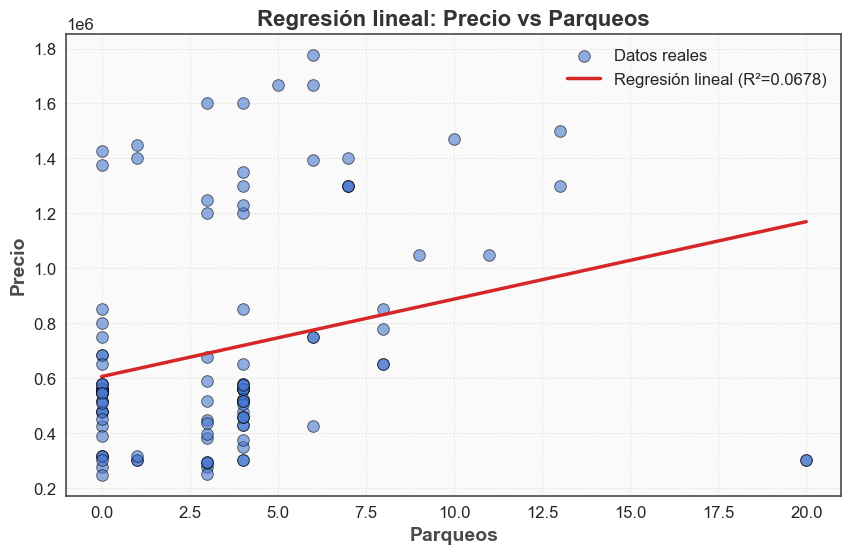

Modelo de regresión lineal: Precio vs Parqueos
R² = 0.0678



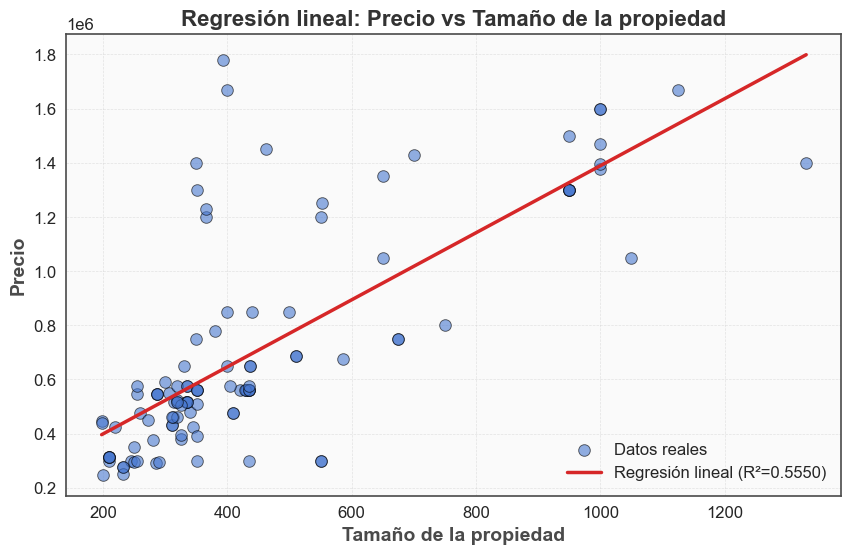

Modelo de regresión lineal: Precio vs Tamaño de la propiedad
R² = 0.5550



In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import os

# Configuración de estilo más limpio y profesional
sns.set_style("white")
sns.set_palette("muted")
plt.rcParams.update({
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.figsize": (10, 6),
    "grid.alpha": 0.3,
    "axes.edgecolor": "#4A4A4A",
    "axes.linewidth": 1.2
})

# Cargar los datos
file_path = "P2-Scraping/properties_zona15.csv"
df = pd.read_csv(file_path)

# Definir la variable dependiente (Precio) y las variables independientes
variables = ["Dormitorios", "Baños", "Parqueos", "Tamaño de la propiedad"]

# Crear modelos de regresión lineal
for var in variables:
    X = df[[var]]  # Variable independiente
    y = df["Precio"]  # Variable dependiente
    
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    
    # Graficar con estilo más limpio y elegante
    plt.figure(figsize=(10, 6))
    ax = sns.scatterplot(x=X[var], y=y, label='Datos reales', alpha=0.6, edgecolor='black', s=70)
    sns.lineplot(x=X[var], y=y_pred, color='#D62728', linewidth=2.5, label=f'Regresión lineal (R²={r2:.4f})')
    
    ax.set_facecolor('#FAFAFA')  # Fondo gris claro más limpio
    plt.xlabel(var, fontsize=14, fontweight='bold', color="#4A4A4A")
    plt.ylabel("Precio", fontsize=14, fontweight='bold', color="#4A4A4A")
    plt.title(f"Regresión lineal: Precio vs {var}", fontsize=16, fontweight='bold', color="#333333")
    plt.legend(frameon=False)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    plt.show()
    
    # Imprimir resultados
    print(f"Modelo de regresión lineal: Precio vs {var}")
    print(f"R² = {r2:.4f}\n")
